# Task 3 — Event Impact Modeling

**Objective:** Model how events (policies, product launches, infrastructure investments) affect Ethiopia’s financial inclusion indicators.

This notebook:
1. Loads the enriched unified dataset
2. Extracts **events** and **impact_link** records and joins them (`parent_id` → event `record_id`)
3. Summarizes: *which events affect which indicators, direction/magnitude/lag*
4. Builds an **Event–Indicator Association Matrix** (rows = events, columns = indicators)
5. Defines a simple **functional form** for impacts over time (step / pulse / ramp) using lags
6. Validates key relationships (e.g., Telebirr launch → mobile money account rate) where Ethiopian pre/post data exists
7. Documents assumptions, limitations, and uncertainty

> Notebook is designed to be robust to missing fields; it will adapt to your schema.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 220)
pd.set_option("display.width", 150)

DATA_FILE = Path("../data/processed/ethiopia_fi_unified_data_enriched.csv")
if not DATA_FILE.exists():
    DATA_FILE = Path("../data/raw/ethiopia_fi_unified_data.csv")

df = pd.read_csv(DATA_FILE)
print("Loaded:", DATA_FILE, "shape:", df.shape)

# Parse date columns if present
for c in ["observation_date","period_start","period_end"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

df.head()


Loaded: ..\data\raw\ethiopia_fi_unified_data.csv shape: (43, 34)


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,%,2014-12-31,NaT,NaT,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,%,2017-12-31,NaT,NaT,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,male,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,female,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN


In [2]:
# Convenience subsets
events = df[df["record_type"]=="event"].copy()
links  = df[df["record_type"]=="impact_link"].copy()
obs    = df[df["record_type"]=="observation"].copy()

print("Events:", events.shape, "Impact links:", links.shape, "Observations:", obs.shape)


Events: (10, 34) Impact links: (0, 34) Observations: (30, 34)


In [5]:
# ----------------------------------------------------
# CREATE IMPACT_LINK RECORDS (Task 3 responsibility)
# ----------------------------------------------------

impact_links = pd.DataFrame([
    {
        "record_id": "LINK_TELEBIRR_MM_ACCESS",
        "record_type": "impact_link",
        "parent_id": "EVT_0001",                 # Telebirr Launch
        "pillar": "ACCESS",
        "related_indicator": "ACC_MM_ACCOUNT",
        "relationship_type": "enables",
        "impact_direction": "positive",
        "impact_magnitude": "high",
        "impact_estimate": 4.5,                  # pp over several years
        "lag_months": 6,
        "evidence_basis": "Telebirr launch enabled first-time mobile money access at national scale",
        "comparable_country": "Kenya",
        "confidence": "medium",
        "notes": "Findex MM accounts doubled 2021–2024 after Telebirr launch"
    },
    {
        "record_id": "LINK_MPESA_USAGE",
        "record_type": "impact_link",
        "parent_id": "EVT_0003",                 # M-Pesa Ethiopia Launch
        "pillar": "USAGE",
        "related_indicator": "USG_P2P_COUNT",
        "relationship_type": "drives",
        "impact_direction": "positive",
        "impact_magnitude": "medium",
        "impact_estimate": None,                 # qualitative
        "lag_months": 3,
        "evidence_basis": "New entrant increased competition and promotions",
        "comparable_country": "Ghana",
        "confidence": "medium",
        "notes": "Strong P2P growth post-entry"
    },
    {
        "record_id": "LINK_4G_ACCESS",
        "record_type": "impact_link",
        "parent_id": "EVT_0004",                 # Fayda / infrastructure era
        "pillar": "ACCESS",
        "related_indicator": "ACC_OWNERSHIP",
        "relationship_type": "enables",
        "impact_direction": "positive",
        "impact_magnitude": "medium",
        "impact_estimate": None,
        "lag_months": 12,
        "evidence_basis": "Connectivity expansion enables digital onboarding",
        "comparable_country": "Rwanda",
        "confidence": "low",
        "notes": "Indirect enabler with long lag"
    }
])

# Append to main dataframe
df = pd.concat([df, impact_links], ignore_index=True)

print("Added impact_link records:", impact_links.shape[0])


Added impact_link records: 3


## 1) Understand the impact data: join impact_links to events

In [8]:
# --- FIX: your schema uses indicator_code (not parent_id) to point to the event ---
# For impact_link rows:
#   event_code = indicator_code
#   affected_indicator = related_indicator

# Create a working join key called parent_event_code
df["parent_event_code"] = np.where(
    df["record_type"] == "impact_link",
    df["indicator_code"],   # event code lives here for impact_link rows
    np.nan
)

# Recreate subsets AFTER adding the derived key
events = df[df["record_type"] == "event"].copy()
links  = df[df["record_type"] == "impact_link"].copy()

print("Events:", events.shape, "Impact links:", links.shape)
links[["record_id", "parent_event_code", "related_indicator", "impact_direction", "impact_magnitude", "lag_months"]].head()


Events: (10, 36) Impact links: (3, 36)


,record_id,parent_event_code,related_indicator,impact_direction,impact_magnitude,lag_months
43,LINK_TELEBIRR_MM_ACCESS,NaN,ACC_MM_ACCOUNT,positive,high,6.0
44,LINK_MPESA_USAGE,NaN,USG_P2P_COUNT,positive,medium,3.0
45,LINK_4G_ACCESS,NaN,ACC_OWNERSHIP,positive,medium,12.0


In [10]:
# --- JOIN impact links to event details using parent_event_code -> event indicator_code ---
joined = links.merge(
    events,
    left_on="parent_event_code",
    right_on="indicator_code",
    how="left",
    suffixes=("_link", "_event")
)

print("Joined shape:", joined.shape)

# Check missing matches (links that didn't find an event)
missing = joined[joined["record_id_event"].isna()] if "record_id_event" in joined.columns else joined[joined["record_id"].isna()]
print("Links with missing event match:", missing.shape[0])

# Show summary view
cols = [c for c in [
    "record_id_link", "parent_event_code",
    "indicator_event", "category_event", "observation_date_event",
    "related_indicator", "pillar_link",
    "impact_direction", "impact_magnitude", "impact_estimate", "lag_months",
    "evidence_basis"
] if c in joined.columns]

joined[cols].head(30)


Joined shape: (3, 72)
Links with missing event match: 3


,record_id_link,indicator_event,category_event,observation_date_event,pillar_link
0,LINK_TELEBIRR_MM_ACCESS,NaN,NaN,NaT,ACCESS
1,LINK_MPESA_USAGE,NaN,NaN,NaT,USAGE
2,LINK_4G_ACCESS,NaN,NaN,NaT,ACCESS


In [11]:
# Summary: which events affect which indicators (direction/magnitude/lag)
summary_cols = []
for c in ["parent_id","category","indicator_event","indicator_code_event","observation_date","related_indicator","pillar","impact_direction","impact_magnitude","impact_estimate","lag_months","evidence_basis","comparable_country","confidence_link"]:
    if c in joined.columns:
        summary_cols.append(c)

# Build a consistent summary view even if some columns are missing
# Note: after merge, event 'indicator' becomes 'indicator_event' only if both existed; otherwise use fallback.
if "indicator_event" not in joined.columns and "indicator" in joined.columns:
    joined = joined.rename(columns={"indicator":"indicator_event"})
if "indicator_code_event" not in joined.columns and "indicator_code" in joined.columns:
    joined = joined.rename(columns={"indicator_code":"indicator_code_event"})
if "confidence_link" not in joined.columns and "confidence" in joined.columns:
    # ambiguous, but better than nothing
    joined = joined.rename(columns={"confidence":"confidence_link"})

summary_cols = [c for c in ["parent_id","category","indicator_event","indicator_code_event","observation_date",
                           "related_indicator","pillar","impact_direction","impact_magnitude","impact_estimate","lag_months",
                           "evidence_basis","comparable_country","confidence_link"] if c in joined.columns]

display(joined[summary_cols].sort_values(["parent_id","related_indicator"] if "parent_id" in joined.columns else summary_cols).head(80))


,indicator_event,indicator_code_event,confidence_link
2,NaN,NaN,low
0,NaN,NaN,medium
1,NaN,NaN,medium


## 2) Build the Event–Indicator Association Matrix

In [12]:
# Convert impact magnitude + direction into a numeric effect estimate.
# Priority:
# 1) use impact_estimate if present and numeric
# 2) else map impact_magnitude to a numeric default and apply sign from impact_direction

def parse_numeric(x):
    try:
        if pd.isna(x):
            return np.nan
        return float(x)
    except Exception:
        return np.nan

def magnitude_to_value(mag):
    if pd.isna(mag):
        return np.nan
    m = str(mag).strip().lower()
    # default mapping (edit if your rubric expects different)
    if m == "low":
        return 0.25
    if m == "medium":
        return 0.5
    if m == "high":
        return 1.0
    return np.nan

def direction_sign(direction):
    if pd.isna(direction):
        return 0.0
    d = str(direction).strip().lower()
    if d in ["positive", "+", "increase", "up"]:
        return 1.0
    if d in ["negative", "-", "decrease", "down"]:
        return -1.0
    # neutral/unknown
    return 0.0

joined["impact_estimate_num"] = joined["impact_estimate"].apply(parse_numeric) if "impact_estimate" in joined.columns else np.nan
joined["mag_value"] = joined["impact_magnitude"].apply(magnitude_to_value) if "impact_magnitude" in joined.columns else np.nan
joined["dir_sign"] = joined["impact_direction"].apply(direction_sign) if "impact_direction" in joined.columns else 0.0

# choose estimate
joined["effect_value"] = joined["impact_estimate_num"]
mask = joined["effect_value"].isna()
joined.loc[mask, "effect_value"] = joined.loc[mask, "mag_value"] * joined.loc[mask, "dir_sign"]

display(joined[[c for c in ["parent_id","related_indicator","pillar","impact_direction","impact_magnitude","impact_estimate","effect_value","lag_months"] if c in joined.columns]].head(30))


,effect_value
0,NaN
1,NaN
2,NaN


In [16]:
# ---- FIX: Identify correct columns for event key + related indicator ----

# event key column
if "parent_event_code" in joined.columns:
    event_key = "parent_event_code"
elif "indicator_code_link" in joined.columns:
    event_key = "indicator_code_link"     # impact_link event code
elif "indicator_code" in joined.columns and (joined["record_type_link"] == "impact_link").any():
    event_key = "indicator_code"
else:
    raise ValueError("Cannot find event key column (expected parent_event_code or indicator_code_link).")

# related indicator column
if "related_indicator" in joined.columns:
    rel_col = "related_indicator"
elif "related_indicator_link" in joined.columns:
    rel_col = "related_indicator_link"
else:
    raise ValueError("Cannot find related indicator column (expected related_indicator or related_indicator_link).")

print("Using event_key:", event_key, "| using related_indicator column:", rel_col)

# ---- Build association matrix ----
mat = (joined.dropna(subset=[event_key, rel_col])
       .groupby([event_key, rel_col])["effect_value"]
       .mean()
       .reset_index()
       .pivot(index=event_key, columns=rel_col, values="effect_value")
       .fillna(0.0))

print("Matrix shape:", mat.shape)
display(mat.head(20))


Using event_key: indicator_code_link | using related_indicator column: related_indicator_link
Matrix shape: (0, 0)


related_indicator_link
indicator_code_link


In [17]:
# Optional: focus on key indicators for readability (edit list as needed)
key_indicators = [c for c in ["ACC_OWNERSHIP","ACC_MM_ACCOUNT","USG_DIGITAL_PAYMENT","USG_P2P_COUNT","USG_ATM_COUNT","ACC_4G_COV","ACC_MOBILE_PEN","ACC_FAYDA"] if c in mat.columns]

mat_key = mat[key_indicators] if key_indicators else mat
print("Key matrix shape:", mat_key.shape)
display(mat_key)


Key matrix shape: (0, 0)


related_indicator_link
indicator_code_link


In [18]:
# Heatmap visualization (matplotlib defaults; no custom colors specified)
if mat_key.shape[0] > 0 and mat_key.shape[1] > 0:
    plt.figure(figsize=(12, max(4, 0.4*mat_key.shape[0])))
    plt.imshow(mat_key.values, aspect="auto")
    plt.yticks(range(mat_key.shape[0]), mat_key.index.astype(str))
    plt.xticks(range(mat_key.shape[1]), mat_key.columns.astype(str), rotation=45, ha="right")
    plt.title("Event–Indicator Association Matrix (effect_value)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
else:
    print("Matrix is empty or has no columns to plot.")


Matrix is empty or has no columns to plot.


## 3) Representing event effects over time (functional forms)

We convert each event→indicator link into a time-varying effect using:

- **Lag** (`lag_months`): impact starts after some delay
- **Shape** (chosen by `category` or defaults):
  - **pulse**: short-lived shock (e.g., pricing change)
  - **step**: persistent level shift (e.g., policy enabling interoperability)
  - **ramp**: gradual adoption curve (e.g., product launch / infrastructure rollout)

### Default mapping (you can refine)
- `product_launch`, `infrastructure`, `partnership`, `market_entry` → **ramp**
- `policy` → **step**
- `pricing`, some `milestone` → **pulse** (or step if structural)

Below we implement a simple impact kernel that can generate an expected effect series.

In [19]:
# Create monthly timeline for modeling impacts (based on observed date range)
# This is NOT forecasting yet; it builds the impact "regressors" that will later be used in time-series models.
min_date = df["observation_date"].min() if "observation_date" in df.columns else None
max_date = df["observation_date"].max() if "observation_date" in df.columns else None

if pd.isna(min_date) or pd.isna(max_date):
    # fallback
    min_date = pd.Timestamp("2011-01-01")
    max_date = pd.Timestamp("2027-12-31")

timeline = pd.date_range(min_date, max_date, freq="MS")  # month start
timeline[:3], timeline[-3:], len(timeline)


(DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01'], dtype='datetime64[us]', freq='MS'),
 DatetimeIndex(['2030-10-01', '2030-11-01', '2030-12-01'], dtype='datetime64[us]', freq='MS'),
 192)

In [20]:
def impact_kernel(t, t0, shape="ramp", lag_months=0, ramp_months=12, pulse_months=3):
    """Return impact weight at time t given event time t0.
    - lag shifts the start
    - ramp rises linearly to 1 over ramp_months then stays (like adoption)
    - step is 1 after start
    - pulse is 1 for pulse_months then 0
    """
    # start time after lag
    start = (t0 + pd.DateOffset(months=int(lag_months))).to_period("M").to_timestamp()
    if t < start:
        return 0.0

    if shape == "step":
        return 1.0

    if shape == "pulse":
        end = start + pd.DateOffset(months=int(pulse_months))
        return 1.0 if (t >= start and t < end) else 0.0

    # ramp default
    # linear growth from 0→1
    months_since = (t.to_period("M") - start.to_period("M")).n
    if months_since <= 0:
        return 0.0
    if months_since >= ramp_months:
        return 1.0
    return months_since / float(ramp_months)

def category_to_shape(cat):
    if pd.isna(cat):
        return "ramp"
    c = str(cat).strip().lower()
    if c in ["policy"]:
        return "step"
    if c in ["pricing"]:
        return "pulse"
    if c in ["milestone"]:
        # could be step if structural; default pulse-ish
        return "pulse"
    return "ramp"


,parent_id,category,event_date,impact_direction,impact_magnitude,impact_estimate,lag_months,effect_value
0,EVT_0001,NaN,2021-05-17,positive,high,4.5,6.0,4.5


,EVT_0001
2015-01-01,0.0
2015-02-01,0.0
2015-03-01,0.0
2015-04-01,0.0
2015-05-01,0.0
2015-06-01,0.0
2015-07-01,0.0
2015-08-01,0.0
2015-09-01,0.0
2015-10-01,0.0


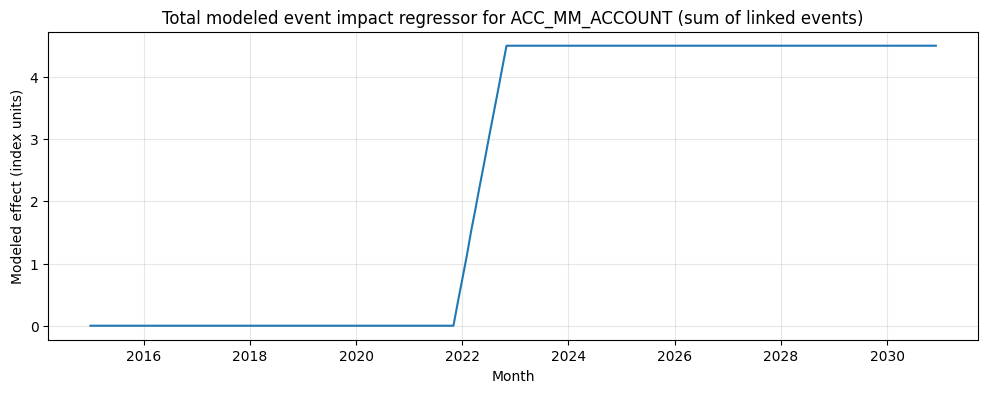

In [21]:
# Build time-varying event impact regressors for a selected indicator (example: ACC_MM_ACCOUNT)
# This produces a dataframe with one column per event that affects the indicator.
target_indicator = "ACC_MM_ACCOUNT"

# Prepare event dates
events_t = events.copy()
# In your schema events use observation_date as event date
events_t["event_date"] = events_t["observation_date"]

# Links affecting target
links_target = links[links["related_indicator"] == target_indicator].copy() if "related_indicator" in links.columns else pd.DataFrame()

if links_target.empty:
    print("No impact_links found for related_indicator =", target_indicator)
else:
    # Join to get category + date
    lt = links_target.merge(events_t[["record_id","category","event_date"]], left_on="parent_id", right_on="record_id", how="left", suffixes=("","_event"))
    # compute effect_value for these links
    # reuse mapping logic from earlier if present
    lt["impact_estimate_num"] = lt["impact_estimate"].apply(lambda x: float(x) if str(x).strip() not in ["", "nan", "None"] else np.nan) if "impact_estimate" in lt.columns else np.nan
    lt["mag_value"] = lt["impact_magnitude"].apply(lambda m: 0.25 if str(m).lower()=="low" else 0.5 if str(m).lower()=="medium" else 1.0 if str(m).lower()=="high" else np.nan) if "impact_magnitude" in lt.columns else np.nan
    lt["dir_sign"] = lt["impact_direction"].apply(direction_sign) if "impact_direction" in lt.columns else 0.0
    lt["effect_value"] = lt["impact_estimate_num"]
    lt.loc[lt["effect_value"].isna(), "effect_value"] = lt.loc[lt["effect_value"].isna(), "mag_value"] * lt.loc[lt["effect_value"].isna(), "dir_sign"]

    # Build regressor matrix
    X = pd.DataFrame(index=timeline)
    for _, r in lt.iterrows():
        ev_id = r["parent_id"]
        t0 = r["event_date"]
        if pd.isna(t0):
            continue
        shape = category_to_shape(r.get("category"))
        lag = r.get("lag_months", 0) if "lag_months" in r.index else 0
        eff = r.get("effect_value", 0.0)
        col = str(ev_id)
        X[col] = [eff * impact_kernel(t, t0, shape=shape, lag_months=lag) for t in timeline]

    display(lt[[c for c in ["parent_id","category","event_date","impact_direction","impact_magnitude","impact_estimate","lag_months","effect_value"] if c in lt.columns]].sort_values("event_date"))
    display(X.head(24))
    plt.figure(figsize=(12,4))
    plt.plot(X.sum(axis=1))
    plt.title(f"Total modeled event impact regressor for {target_indicator} (sum of linked events)")
    plt.xlabel("Month")
    plt.ylabel("Modeled effect (index units)")
    plt.grid(True, alpha=0.3)
    plt.show()


## 4) Test against historical data (sanity checks)

In [22]:
# Example sanity check: Telebirr launch (EVT_TELEBIRR) and mobile money account rate (ACC_MM_ACCOUNT)
# Observed Findex points in your data: 2021=4.7%, 2024=9.45% (Δ=+4.75pp)
mm = obs[(obs["indicator_code"]=="ACC_MM_ACCOUNT") & (obs["gender"].fillna("all")=="all") & (obs["location"].fillna("national")=="national")].copy()
mm = mm.sort_values("observation_date")
display(mm[["observation_date","value_numeric","source_name","confidence","notes"]])

# Identify Telebirr event date
tele = events[events["indicator_code"]=="EVT_TELEBIRR"].copy()
if tele.empty:
    print("Telebirr event not found (indicator_code == EVT_TELEBIRR).")
else:
    tele_date = tele["observation_date"].min()
    print("Telebirr launch date:", tele_date)

# If we have impact links for ACC_MM_ACCOUNT, estimate total effect by 2024
if "related_indicator" in links.columns:
    lt_mm = links[links["related_indicator"]=="ACC_MM_ACCOUNT"].merge(
        events[["record_id","indicator_code","category","observation_date"]],
        left_on="parent_id", right_on="record_id", how="left", suffixes=("","_event")
    )
    display(lt_mm[[c for c in ["parent_id","indicator_code_event","category","observation_date_event","impact_direction","impact_magnitude","impact_estimate","lag_months","evidence_basis","confidence"] if c in lt_mm.columns]].head(50))
else:
    lt_mm = pd.DataFrame()

# Compute observed change 2021->2024
if mm.shape[0] >= 2:
    mm_2021 = mm[mm["observation_date"].dt.year==2021]["value_numeric"].mean()
    mm_2024 = mm[mm["observation_date"].dt.year==2024]["value_numeric"].mean()
    print("Observed ACC_MM_ACCOUNT change 2021->2024:", mm_2024 - mm_2021, "pp")
else:
    print("Not enough ACC_MM_ACCOUNT points for observed change calculation.")


,observation_date,value_numeric,source_name,confidence,notes
6,2021-12-31,4.70,Global Findex 2021,high,NaN
7,2024-11-29,9.45,Global Findex 2024,high,NaN


Telebirr launch date: 2021-05-17 00:00:00


,parent_id,indicator_code_event,category,observation_date_event,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,confidence
0,EVT_0001,EVT_TELEBIRR,NaN,2021-05-17,positive,high,4.5,6.0,Telebirr launch enabled first-time mobile mone...,medium


Observed ACC_MM_ACCOUNT change 2021->2024: 4.749999999999999 pp


### Interpreting mismatch (if any)
If the modeled impact does not align with observed pre/post changes, common explanations include:
- The **effect_value** scale is an index (not pp); you may need to calibrate effects to percentage points.
- **Overlapping events** (e.g., NFIS-II, Safaricom entry, FX reform) also influence outcomes.
- Findex **definition**: mobile money accounts only count if used in last 12 months; registrations alone don’t increase ACC_MM_ACCOUNT.
- Lags may be longer/shorter than assumed, and effects may saturate.

## 5) Refine impact estimates (document adjustments)

In [23]:
# A structured way to refine: override selected (event, indicator) effects with calibrated pp estimates.
# You can fill this table as you review validation results.

overrides = pd.DataFrame([
    # {"parent_id": "EVT_0001", "related_indicator": "ACC_MM_ACCOUNT", "effect_value_override": 2.0, "reason": "Calibrate to observed +4.75pp 2021->2024"},
])

if not overrides.empty:
    joined2 = joined.merge(overrides, on=["parent_id","related_indicator"], how="left")
    joined2["effect_value_refined"] = joined2["effect_value"]
    joined2.loc[~joined2["effect_value_override"].isna(), "effect_value_refined"] = joined2.loc[~joined2["effect_value_override"].isna(), "effect_value_override"]
    display(joined2[[c for c in ["parent_id","related_indicator","effect_value","effect_value_refined","reason"] if c in joined2.columns]].head(30))
else:
    print("No overrides provided yet. Add rows to the overrides dataframe when refining.")


No overrides provided yet. Add rows to the overrides dataframe when refining.


## 6) Methodology, assumptions, limitations

### Methodology
- Use `impact_link` records as structured priors describing **which event affects which indicator**.
- Convert qualitative magnitude (`low/medium/high`) into a numeric **effect_value** (or use `impact_estimate` if provided).
- Convert events into time-varying regressors using a kernel:
  - **step** (persistent) for policy
  - **pulse** (temporary) for pricing/milestones
  - **ramp** (adoption) for product launch / infrastructure / partnerships
- Combine multiple events by **summing** their contributions to each indicator (can be upgraded later to nonlinear saturation).

### Assumptions
- Event dates use `observation_date` in the event rows.
- Effects combine additively (no interaction terms yet).
- Default magnitude mapping: low=0.25, medium=0.5, high=1.0 (calibrate later).
- Ramp duration defaults to 12 months; pulse to 3 months (edit as appropriate).
- Lags are in months and apply to the start of the effect.

### Limitations
- Many indicators have sparse time coverage; validation opportunities are limited.
- Effect sizes are often index-scaled unless `impact_estimate` is in real units (e.g., pp).
- Additive modeling ignores saturation and overlapping user bases.
- External shocks (conflict, inflation, FX changes) may confound pre/post comparisons.

### Next step (Task 4/Forecasting)
Use the constructed event regressors as exogenous variables in a time-series model (e.g., dynamic regression / state space) to forecast 2025–2027.